# Data exploration

In [1]:
from collections import Counter, defaultdict
from scipy.stats import norm
import math, random, csv
import matplotlib.pyplot as plt
from numpy import shape

In [2]:
def bucketize(point, bucket_size):
    # floor the point to the next lower multiple of bucket_size
    return bucket_size * math.floor(point / bucket_size)

In [3]:
def make_histogram(points, bucket_size):
    # buckets the points and counts how many in each bucket
    return Counter(bucketize(point, bucket_size) for point in points)

In [4]:
def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

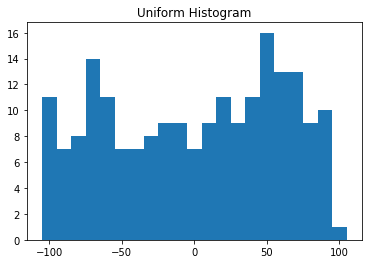

In [5]:
uniform = [random.randrange(-100,101) for _ in range(200)]
plot_histogram(uniform, 10, "Uniform Histogram")

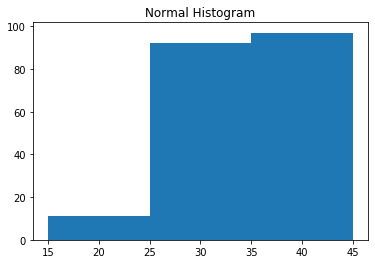

In [6]:
normal = [57 * norm.cdf(random.random())
              for _ in range(200)]
plot_histogram(normal, 10, "Normal Histogram")

In [7]:
def random_normal():
    # returns a random draw from a standard normal distribution
    return norm.ppf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

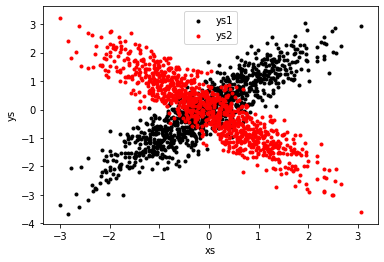

In [8]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='red',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)

In [9]:
def correlation_matrix(data):
    # returns the num_columns x num_columns matrix whose (i, j)th entry
    # is the correlation between columns i and j of data

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)

In [10]:
def make_scatterplot_matrix():

    # first, generate some random data

    num_points = 100

    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row()
            for _ in range(num_points)]

    # then plot it

    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())

# Cleaning and formatting

In [11]:
def parse_row(input_row, parsers):
    # given a list of parsers (some of which may be None)
    # apply the appropriate one to each element of the input_row
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

In [12]:
def parse_rows_with(reader, parsers):
    # wrap a reader to apply the parsers to each of its rows
    for row in reader:
        yield parse_row(row, parsers)

In [13]:
def try_or_none(f):
    # wraps f to return None if f raises an exception
    # assumes f takes only one input
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

In [14]:
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

In [15]:
def try_parse_field(field_name, value, parser_dict):
    # try to parse value using the appropriate function from parser_dict
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

In [16]:
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
             for field_name, value in input_dict.items() }

# Manipulating data

In [17]:
def picker(field_name):
    # returns a function that picks a field out of a dict
    return lambda row: row[field_name]


def pluck(field_name, rows):
    # turn a list of dicts into the list of field_name values
    return map(picker(field_name), rows)


def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.items() }

In [18]:
def percent_price_change(yesterday, today):
    return today['closing_price'] / yesterday['closing_price'] - 1


def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ 'symbol' : today['symbol'],
              'date' : today['date'],
              'change' : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]

# Rescaling

In [19]:
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist

In [20]:
a_to_b = calculateDistance(63, 150, 67, 160)
a_to_b

10.770329614269007

In [21]:
a_to_c = calculateDistance(63, 150, 70, 171)
a_to_c

22.135943621178654

In [22]:
b_to_c = calculateDistance(67, 160, 70, 171)
b_to_c

11.40175425099138

In [23]:
a_to_b = calculateDistance(160, 150, 170.2, 160)
a_to_b

14.284257068535268

In [24]:
a_to_c = calculateDistance(160, 150, 177.8, 171)
a_to_c

27.52889391167034

In [25]:
b_to_c = calculateDistance(170.2, 160, 177.8, 171)
b_to_c

13.370115930686627

In [26]:
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

In [27]:
def rescale(data_matrix):
    # rescales the input data so that each column
    # has mean 0 and standard deviation 1
    # ignores columns with no deviation
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

# Dimensionality reduction

In [41]:
def de_mean_matrix(A):
    # returns the result of subtracting from every value in A the mean
    # value of its column. the resulting matrix has mean 0 in every column
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

In [42]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [43]:
def directional_variance_i(x_i, w):
    # the variance of the row x_i in the direction w
    return dot(x_i, direction(w)) ** 2

In [44]:
def directional_variance(X, w):
    # the variance of the data in the direction w
    return sum(directional_variance_i(x_i, w) for x_i in X)

In [45]:
def directional_variance_gradient_i(x_i, w):
    # the contribution of row x_i to the gradient of
    # the direction-w variance
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

In [46]:
def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

In [47]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
    return direction(unscaled_maximizer)

In [48]:
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

In [49]:
def project(v, w):
    # return the projection of v onto w
    coefficient = dot(v, w)
    return scalar_multiply(coefficient, w)

In [51]:
def remove_projection_from_vector(v, w):
    # projects v onto w and subtracts the result from v
    return vector_subtract(v, project(v, w))

In [52]:
def remove_projection(X, w):
    # for each row of X
    # projects the row onto w, and subtracts the result from the row
    return [remove_projection_from_vector(x_i, w) for x_i in X]

In [53]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)

    return components

In [54]:
def transform_vector(v, components):
    return [dot(v, w) for w in components]


def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]